# L2 & L3 snapshots fast sampling phase 

Look at doc:

- https://www.aviso.altimetry.fr/fileadmin/documents/data/tools/swot_l3_faqL3alphav0_3_rev1.pdf
- https://swotst.aviso.altimetry.fr/fileadmin/user_upload/SWOTST2023/20230920_ocean_2_regional_calval/16h30-Dibarboure_level3.pdf

Med diags:

- [ ] L2&L3 ssh/sig0 movie
- [ ] L2 ssh thumbnails
- [ ] L2 sigma0 thumbnails
- [ ] L3 ssh thumbnails
- [ ] L3 sig0 thumbnails
- [ ] binned diagnostics

Maluku:

- [ ] L2&L3 ssh/sig0 movie
- [ ] L2 ssh thumbnails
- [ ] L2 sigma0 thumbnails
- [ ] L3 ssh thumbnails
- [ ] L3 sig0 thumbnails
- [ ] L2 HF sig0 (with high/low contributions) storage compensated
- [ ] L2 HF ssh storage compensated 
- [ ] binned diagnostics


In [7]:
import os, sys
from tqdm import tqdm

import numpy as np
import pandas as pd
import xarray as xr
import datetime

import matplotlib.pyplot as plt
#import cartopy
#crs = cartopy.crs.PlateCarree()
#import cartopy.feature as cfeature

import hvplot.xarray
import hvplot.pandas

import pyinterp
import swot_calval.io

sys.path.append("/work/HELPDESK_SWOTLR/swot_diego/libs")
import swot_diego as sd

In [8]:
client, cluster = sd.spin_up_cluster(jobs=2, memory='16GiB', walltime='04:00:00')
#cores=1,
#memory='8GiB', # Balanced configuration should have 8 GiB per core if possible
#cluster.scale(jobs=4)

/work/HELPDESK_SWOTLR/commun/envs/py311_dev/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33437 instead
  warnings.warn(


In [9]:
cluster

SLURMCluster(376c0027, 'tcp://10.11.2.129:38557', workers=0, threads=0, memory=0 B)

---

## utils

```
len(collection.variables()) # 
list(collection.half_orbits())[:5] # acquired passes
list(collection.cycles())[:5] # acquired cycles
collection.period() # first/last partition entry
collection.half_orbit_periods() # half orbit periods
pandas.DataFrame(collection.half_orbit_periods()) # Convert the ORF as a pandas.DataFrame
```

---
## load data

Fix L2 zcoll access:

```
kdestroy
kinit
```


In [4]:
#sd.load_l2(probe_variables=True)
#sd.load_l3(probe_variables=True)

In [13]:
#region = "med_NW_CN"
#region = "med_NW"
region = "maluku"
info = sd.regions[region]

# get passes
#times = sd.get_passes_times(info["coordinates"])

# selected variables
#SSH = ['ssha_karin_2_filtered', 'mean_sea_surface_cnescls', 'cvl_mean_dynamic_topography_cnes_cls_22', 'xcal']
#UV = ['speed_zonal', 'speed_meridional', 'speed_zonal_abs', 'speed_meridional_abs']
#SIG0 = ['sig0_karin_2']
l3_variables = sd.l3["ssh"]+sd.l3["speed"]+sd.l3["sig0"]

half_orbits = sd.load_l3(
    pass_numbers=info["passes"],
    variables=l3_variables,
    first_day=datetime.date(2023, 4, 1),
    last_day=datetime.date(2023, 7, 15),
    geoselection = info['coordinates'],
)

In [6]:
#for (cycle, pass_number), ds in half_orbits.items():
#    # ds = ds.to_xarray()
#    #print(cycle, pass_number, ds.dimensions)
#    pass

```
tuple(half_orbits.keys()) # Print each half-orbit loaded
dict(half_orbits) # Get the dictionary between half-orbits and datasets
half_orbits[(509, 20)] # Retrieve the dataset for a specific half-orbit
```

---

## store data

In [ ]:
if False:
    
    #region = "med_NW_CN"
    #region = "med_NW"
    #region = "maluku"
    #info = sd.regions[region]

    # get passes
    #times = sd.get_passes_times(info["coordinates"])

    # selected variables
    #SSH = ['ssha_karin_2_filtered', 'mean_sea_surface_cnescls', 'cvl_mean_dynamic_topography_cnes_cls_22', 'xcal']
    #UV = ['speed_zonal', 'speed_meridional', 'speed_zonal_abs', 'speed_meridional_abs']
    #SIG0 = ['sig0_karin_2']
    #l3_variables = sd.l3["ssh"]+sd.l3["speed"]+sd.l3["sig0"]

    half_orbits = sd.load_l3(
        pass_numbers=info["passes"],
        #variables=l3_variables,
        first_day=datetime.date(2023, 4, 1),
        last_day=datetime.date(2023, 7, 15),
        geoselection = info['coordinates'],
    )

    out_dir = "/work/scratch/data/pontea/data"
    for (cycle, pass_number), ds in tqdm(half_orbits.items()):
        ds = ds.to_xarray()
        zarr = os.path.join(out_dir, f"L3_{pass_number}_{cycle}.zarr")
        ds.to_zarr(zarr, mode="w")

---
## mean surfaces

### mdt + mean circulation

In [5]:
(cycle, pass_number), zds = next(half_orbits.items())
ds = zds.to_xarray().persist()

Text(0.5, 1.0, 'mdt (cnes_cls_22) + mean circulation')

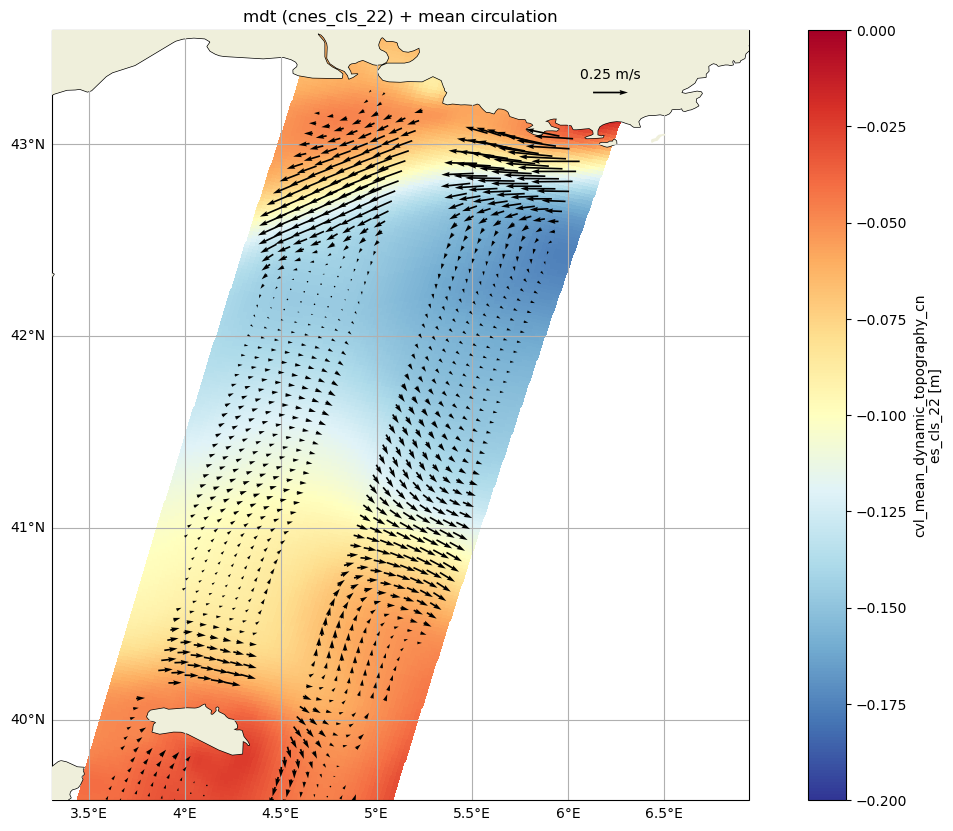

In [8]:
v = 'cvl_mean_dynamic_topography_cnes_cls_22'
vkwargs = dict(cmap='RdYlBu_r', vmin=-.2, vmax=0.) # med_NW
#vkwargs = dict(cmap='RdYlBu_r', vmin=.9, vmax=1.1) # maluku
#v = 'cvl_mean_sea_surface_cnes_22_hybrid'
#vkwargs = dict(cmap='RdYlBu_r', center=False, vmin=30, vmax=70)

ds["mean_speed_zonal"] = ds["speed_zonal_abs"] - ds["speed_zonal"]
ds["mean_speed_meridional"] = ds["speed_meridional_abs"] - ds["speed_meridional"]

a = ('mean_speed_zonal', 'mean_speed_meridional')
akwargs = dict(a=a, a_di=3, a_ref=0.25, akwargs=dict(color="k", scale=5)) # med_NW
#akwargs = dict(a=a, a_di=1, a_ref=0.25, akwargs=dict(color="k", scale=5)) # maluku

fig, ax = sd.plot_l3_map(
    cycle, pass_number, ds, info['extent'], 
    v=v, vkwargs=vkwargs,
    **akwargs,
)
ax.set_title("mdt (cnes_cls_22) + mean circulation")

### geoid (to be checked)

In [9]:
ds["geoid"] = ds['mean_sea_surface_cnescls'] - ds['cvl_mean_dynamic_topography_cnes_cls_22']

Text(0.5, 1.0, 'geoid')

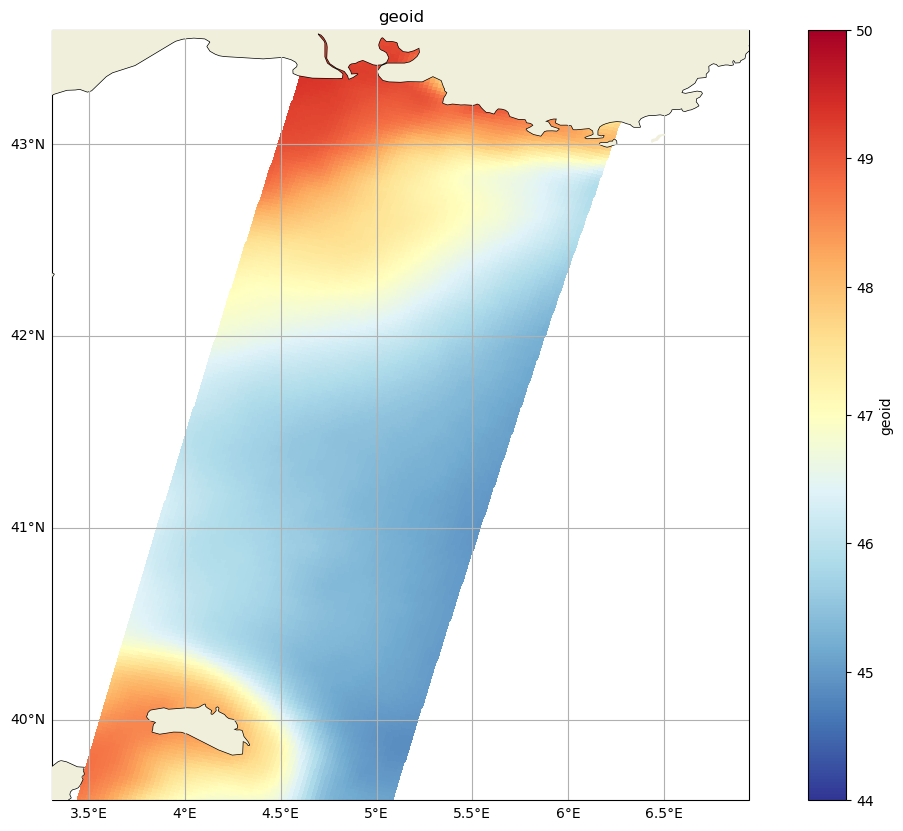

In [10]:
v = 'geoid'
#v = 'mean_sea_surface_cnescls'
#v = 'cvl_mean_dynamic_topography_cnes_cls_22'

vkwargs = dict(cmap='RdYlBu_r', center=False, vmin=44, vmax=50) # med_NW
#vkwargs = dict(cmap='RdYlBu_r', center=False, vmin=30, vmax=70) # maluku

fig, ax = sd.plot_l3_map(
    cycle, pass_number, ds, info['extent'], # [100, 160, -30, 30]
    v=v, vkwargs=vkwargs,
)
ax.set_title("geoid")

---
## meteorological overview

In [11]:
# load wind
location = info["location"]
era5 = sd.load_era5("2023/03/15", "2023/08/01", location=location)

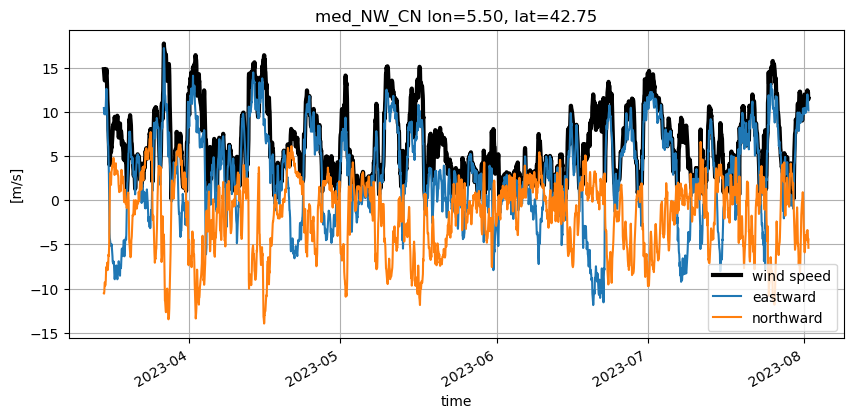

In [10]:
sd.show_wind_teries(era5, label=region)

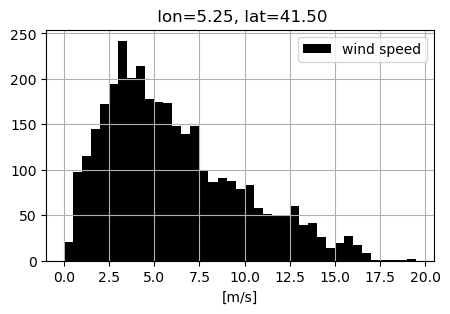

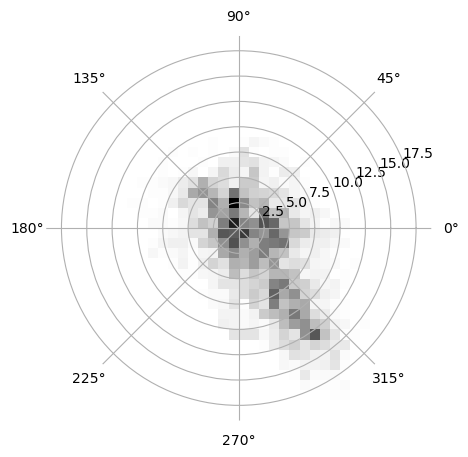

In [8]:
sd.show_wind_hist(era5, np.arange(0,20,.5), np.arange(-20,20,1))

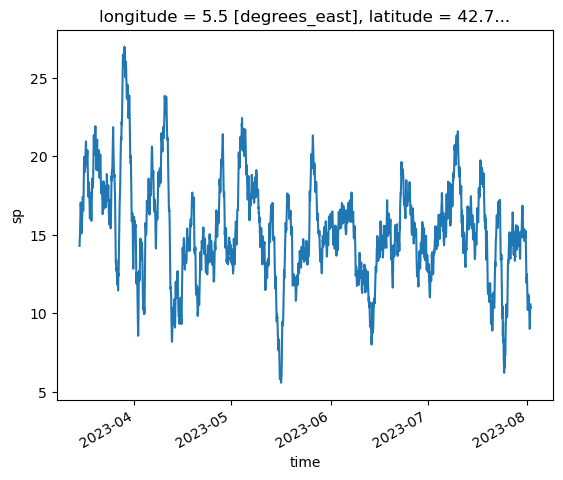

In [11]:
((era5["sp"]/1e5 - 1)*1e3).plot()

In [20]:
_extent = sd.regions["med_NW"]["extent"]
_extent = [_extent[0], _extent[1], _extent[3], _extent[2]]  
era5_2d = sd.load_era5("2023/03/15", "2023/08/01", extent=_extent)

In [27]:
era5_2d

<xarray.Dataset>
Dimensions:      (longitude: 14, latitude: 16, time: 3360)
Coordinates:
  * longitude    (longitude) float32 3.5 3.75 4.0 4.25 4.5 ... 6.0 6.25 6.5 6.75
  * latitude     (latitude) float32 43.5 43.25 43.0 42.75 ... 40.25 40.0 39.75
  * time         (time) datetime64[ns] 2023-03-15 ... 2023-08-01T23:00:00
Data variables:
    u10          (time, latitude, longitude) float32 dask.array<chunksize=(24, 16, 14), meta=np.ndarray>
    v10          (time, latitude, longitude) float32 dask.array<chunksize=(24, 16, 14), meta=np.ndarray>
    iews         (time, latitude, longitude) float32 dask.array<chunksize=(24, 16, 14), meta=np.ndarray>
    inss         (time, latitude, longitude) float32 dask.array<chunksize=(24, 16, 14), meta=np.ndarray>
    swh          (time, latitude, longitude) float32 dask.array<chunksize=(24, 16, 14), meta=np.ndarray>
    shww         (time, latitude, longitude) float32 dask.array<chunksize=(24, 16, 14), meta=np.ndarray>
    sp           (time, latitude, longitude) float32 dask.array<chunksize=(24, 16, 14), meta=np.ndarray>
    wind_speed   (time, latitude, longitude) float32 dask.array<chunksize=(24, 16, 14), meta=np.ndarray>
    wind_stress  (time, latitude, longitude) float32 dask.array<chunksize=(24, 16, 14), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2023-11-05 08:17:16 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

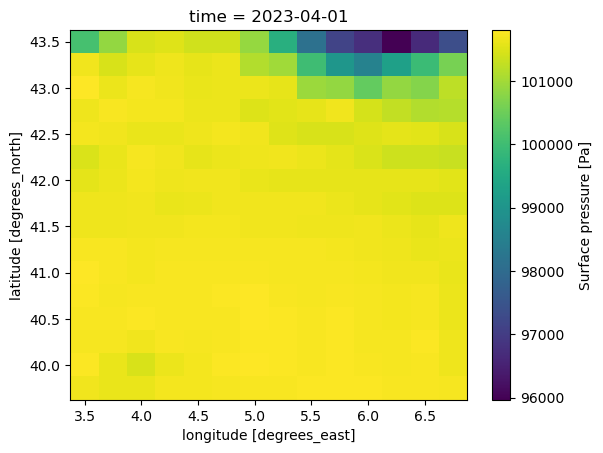

In [25]:
era5_2d["sp"].sel(time="2023-04-01 00:00").plot()

---

## thumbnails overview

In [10]:
# clean figure directory
#sd.clean_figdir()

In [14]:
# run once to get local projection parameters

iterator = half_orbits.items()
(cycle, pass_number), zds = next(iterator)

v = 'ssh'
#v = 'sig0'
level = 'L3'

da, t_min, t_max = sd.load_swot_da(
    zds, v, level=level, 
    extent=info['extent'], geoselection=info["coordinates"], project=True,
)
gproj = {k: da.attrs[k] for k in ["lonc", "latc", "phi"]}

In [8]:
# to get x, y and color limits
#da.plot(x="x", y="y")

In [15]:
def _plot(
    zds, v, cycle, pass_number, 
    ax, 
    level=None,
    xlims=None, ylims=None, extent=None, 
    grid=True,
    mask=None,
    filt_kw={}, normalize=False,
    **kwargs,
):
    
    da = sd.load_swot_da(
        zds, v, level=level, 
        extent=extent, 
        geoselection=info["coordinates"],
        project=gproj,
        mask=mask,
    )
    if da is not None:
        da, time_start, time_end = da
    else:
        time_start, time_end = pd.NaT, pd.NaT
        
    if filt_kw:
        da_high, da_low = sd.mask_filter(da, **filt_kw)
        da = da_high
        if normalize:
            da = da/da_low
    
    if isinstance(da, dict):
        # L2 std
        for side, _da in da.items():
            _da.plot(ax=ax, **kwargs)
    elif da is not None:
        # L3
        da.plot(ax=ax, **kwargs)
    ax.set_xticklabels("")
    ax.set_yticklabels("")
    ax.set_xlabel("")
    ax.set_ylabel("")
    x0, y0 = 0,0
    if xlims is not None:
        ax.set_xlim(xlims)
        x0 = xlims[0]
    if ylims is not None:
        ax.set_ylim(ylims)
        y0 = ylims[0]
    ax.set_aspect("equal", adjustable="box")
    if grid:
        ax.grid()
    ax.set_title("")
    if da is not None:
        time_str = time_start.strftime("%Y/%m/%d %H:%M")
        ax.text(x0, y0, f"{cycle}/{pass_number}\n"+time_str)
    return time_start, time_end

In [13]:
filt_ssh_l2 = dict(spike_threshold=.05, lbd = 20e3,  dx = 250)
filt_ssh_l3 = dict(spike_threshold=.05, lbd = 20e3,  dx = 2.0)
filt_sig0_l2 = dict(spike_threshold=5, lbd = 20e3,  dx = 250, spike_normalize=True)
filt_sig0_l3 = dict(spike_threshold=5, lbd = 20e3,  dx = 2.0, spike_normalize=True)

# L3
v = 'ssha_karin_2_filtered'
vkwargs = dict(
    level="L3",
    vmin=-.2, vmax=.2, 
    #vmin=-.2, vmax=.2, filt_kw=filt_ssh_l3,
    cmap='RdYlBu_r', add_colorbar=False,
    xlims=info["xlims"], ylims=info["ylims"],
    extent=info["extent"],
)

v = 'ssh'
vkwargs = dict(
    level="L3",
    vmin=-.3, vmax=.3, 
    #vmin=.9, vmax=1.4,
    #vmin=-.3, vmax=.3, filt_kw=filt_ssh_l3,
    cmap='RdYlBu_r', add_colorbar=False,
    #xlims=info["xlims"], ylims=info["ylims"],
    extent=info["extent"],
)

# L2
if True:
    v = 'ssh'
    vkwargs = dict(
        level="L2_unsmoothed_cvl",
        #level="L2_unsmoothed_std",
        x="x", y="y", xlims=info["xlims"], ylims=info["ylims"],
        vmin=-.3, vmax=.3, cmap='RdYlBu_r', 
        #vmin=.9, vmax=1.4, cmap='RdYlBu_r', 
        #vmin=-.3, vmax=.3, filt_kw=filt_ssh_l2, cmap='RdBu_r', 
        add_colorbar=False,
        extent=info["extent"],
    )

In [ ]:
sd.thumbnails(
    half_orbits, v, _plot,
    ny=1, nx=6, 
    #figsize=(15,8), # med_NW, maluka
    figsize=(15,8), # med_NW_CN
    suffix=f"{region}_{v}_"+vkwargs["level"],
    dry_run=True,
    **vkwargs
)

Session duration must be between 3600 and 43200 : 
	Duration : None -> 3600
Session duration must be between 3600 and 43200 : 
	Duration : None -> 3600
Session duration must be between 3600 and 43200 : 
	Duration : None -> 3600
Session duration must be between 3600 and 43200 : 
	Duration : None -> 3600
Session duration must be between 3600 and 43200 : 
	Duration : None -> 3600
Session duration must be between 3600 and 43200 : 
	Duration : None -> 3600


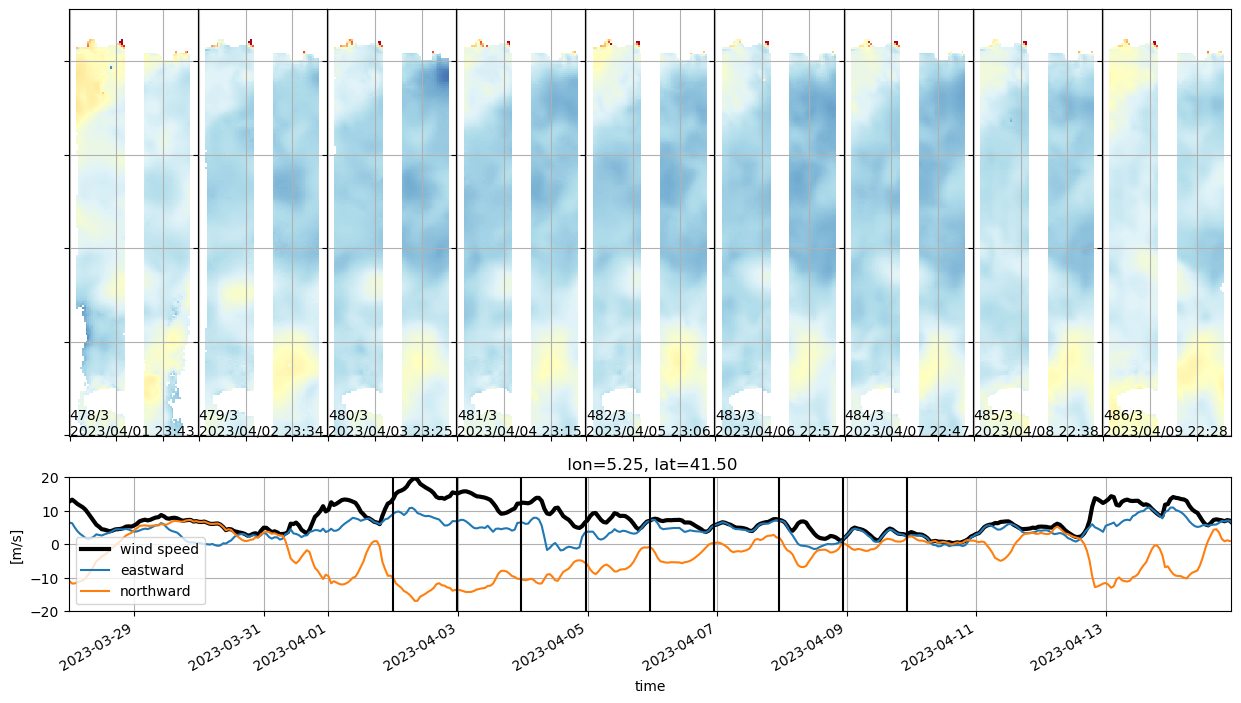

In [21]:
sd.thumbnails_with_wind(
    half_orbits, v, _plot, era5,
    nx=9, 
    figsize=(15,8), # med_NW, maluka
    suffix=f"{region}_{v}_"+vkwargs["level"],
    dry_run=True,
    **vkwargs
)

0it [00:00, ?it/s]

Session duration must be between 3600 and 43200 : 
	Duration : None -> 3600
Session duration must be between 3600 and 43200 : 
	Duration : None -> 3600


0it [00:34, ?it/s]


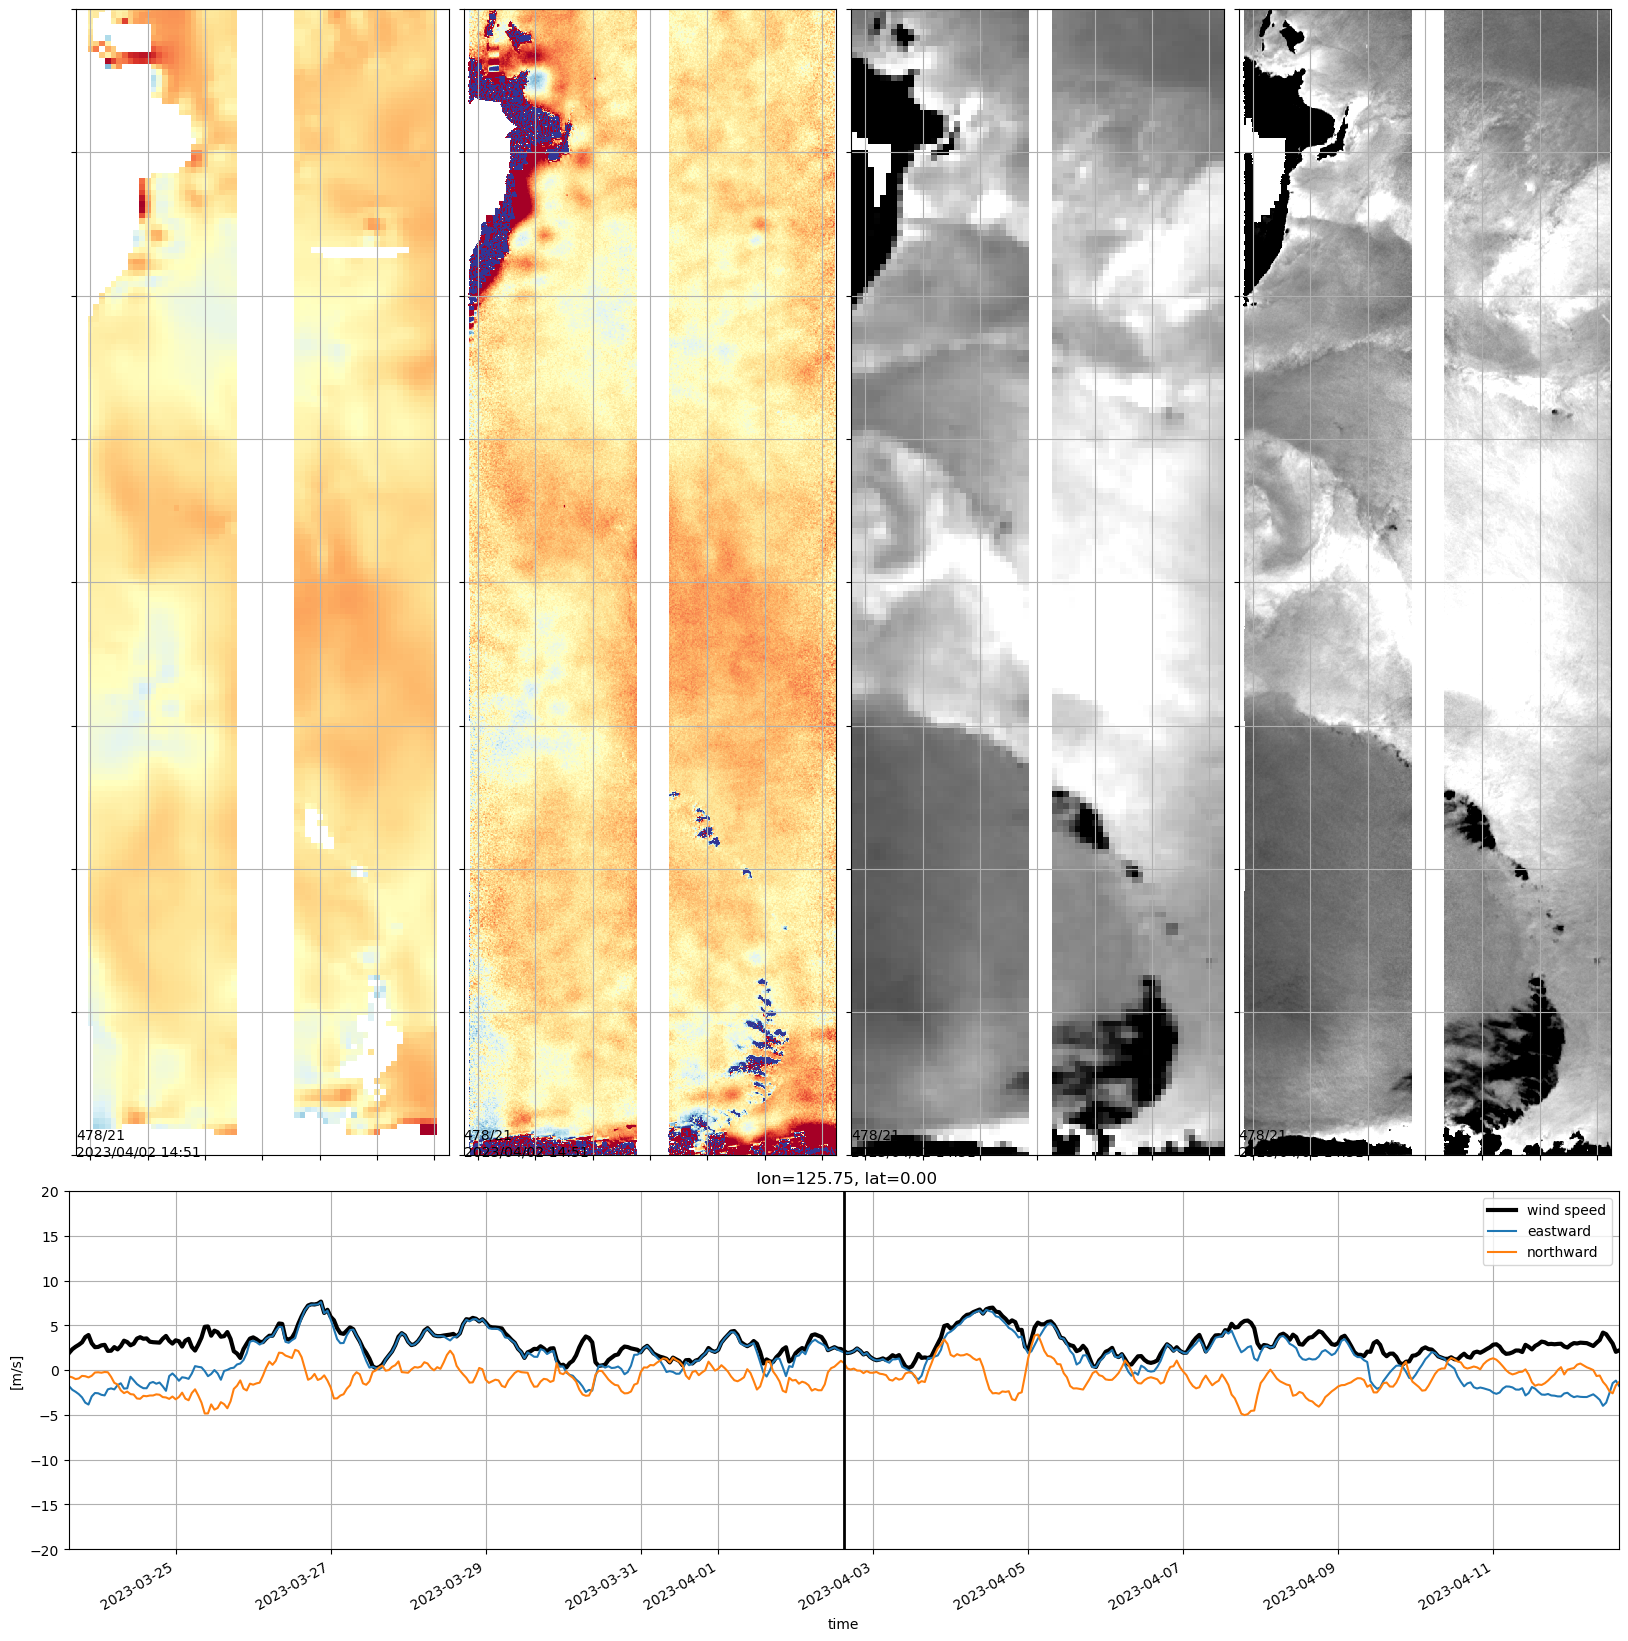

In [16]:
kwargs = dict(x="x", y="y", xlims=info["xlims"], ylims=info["ylims"], add_colorbar=False, extent=info["extent"])

ssh_kw = dict(vmin=-.3, vmax=.3, cmap='RdYlBu_r', mask=1) # med
sig0_kw = dict(vmin=-5, vmax=30, cmap='Greys_r') # med

ssh_kw = dict(vmin=.9, vmax=1.4, cmap='RdYlBu_r') # maluku
#ssh_kw_filt = dict(vmin=-.3, vmax=.3, filt_kw=filt_ssh_l2, cmap='RdBu_r') # maluku
sig0_kw = dict(vmin=10, vmax=60, cmap='Greys_r') # maluku
#sig0_kw_filt = dict(vmin=-50, vmax=50, filt_kw=filt_sig0_l2, cmap='Greys_r') # maluku
#sig0_kw_filt = dict(vmin=-.5, vmax=.5, filt_kw=filt_sig0_l2, normalize=True, cmap='Greys_r') # maluku

variables = [
    dict(label="ssh", level="L3",  **ssh_kw, **kwargs),
    #dict(label="ssh", level="L2_unsmoothed_std", **ssh_kw, **kwargs),
    dict(label="ssh", level="L2_unsmoothed_cvl", **ssh_kw, **kwargs),
    #dict(label="ssh", level="L2_unsmoothed_cvl", **ssh_kw_filt, **kwargs),
    dict(label="sig0", level="L3", **sig0_kw, **kwargs),
    #dict(label="sig0", level="L2_unsmoothed_std", **sig0_kw, **kwargs),
    dict(label="sig0", level="L2_unsmoothed_cvl", **sig0_kw, **kwargs),
    #dict(label="sig0", level="L2_unsmoothed_cvl", **sig0_kw_filt, **kwargs),
]
suffix = f"{region}_ssh_sig0_l2l3"

dry_run = True
#dry_run = False

i=0
for (cycle, pass_number), zds in tqdm(half_orbits.items()):
    sd.thumbnail_multi_variables(
        variables, _plot, era5,
        zds, cycle, pass_number, i,
        #figsize=(10,10), # dev
        figsize=(20,20),
        suffix=suffix, 
        dry_run=dry_run,
    )
    i+=1
    if i>=1 and dry_run:
        break

Produce movie with:

```
conda activate py311_dev
ffmpeg -framerate 2 -pattern_type glob -i '*.png' -c:v libx264 -pix_fmt yuv420p movie.mp4
```

In [13]:
# PhD, Postdoc
121500*1.15, 65600*1.15

(139725.0, 75440.0)

---

## dev

### interpolates mdt on L2 from L3

In [8]:
cycle = 498
pass_number = info["passes"][0]
zds = half_orbits[(cycle, pass_number)]

#iterator = half_orbits.items()
#(cycle, pass_number), zds = next(iterator)
#(cycle, pass_number), zds = next(iterator)

v = 'ssh'
v = 'sig0'
#v = 'sig0_karin_2'
#level = 'L3'
level = 'L2_unsmoothed_cvl'
#level = 'L2_unsmoothed_std'

da = sd.load_swot_da(
    zds, v, level=level, 
    extent=info['extent'], geoselection=info["coordinates"],
    project=gproj,
    #mask=2,
    dev=True,
    #s0_rescale=False,
)

#da, time_min, time_max, ds_l3 = da # L3
da, time_min, time_max, ds_l2, ds_l3 = da # L2
#mask = ds_l2["ssh_karin_2_qual"]
mask = da.mask

Session duration must be between 3600 and 43200 : 
	Duration : None -> 3600


In [9]:
#da_low, da_high, ds = mask_filter(da, spike_threshold=0.05, dev=True) # ssh
da_low, da_high, ds = sd.mask_filter(da, spike_threshold=5, spike_normalize=True, dev=True) # sig0

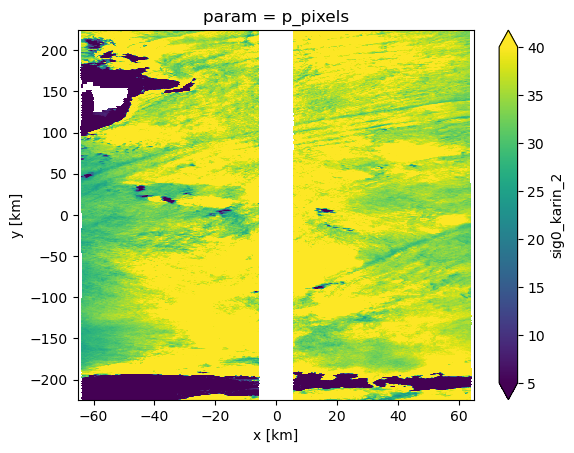

In [10]:
da.plot(x="x", y="y", vmin=5, vmax=40)

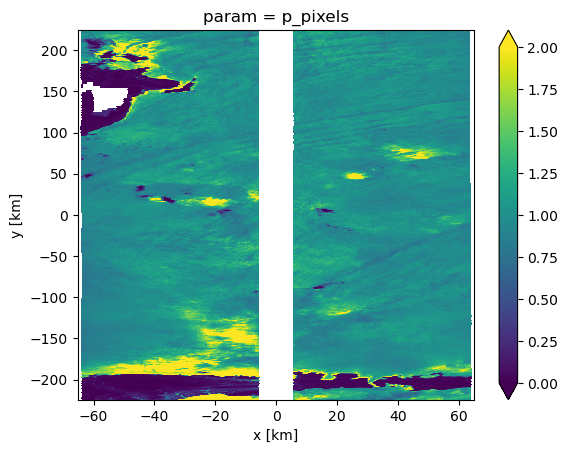

In [11]:
(da/da_low).plot(x="x", y="y", vmin=0, vmax=2)

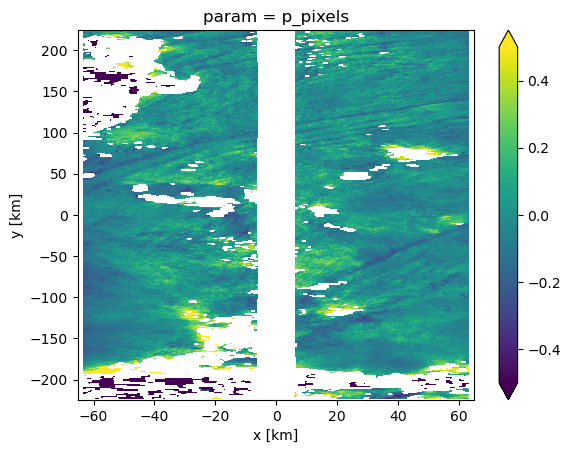

In [21]:
(da_high/da_low).plot(x="x", y="y", vmin=-.5, vmax=.5)

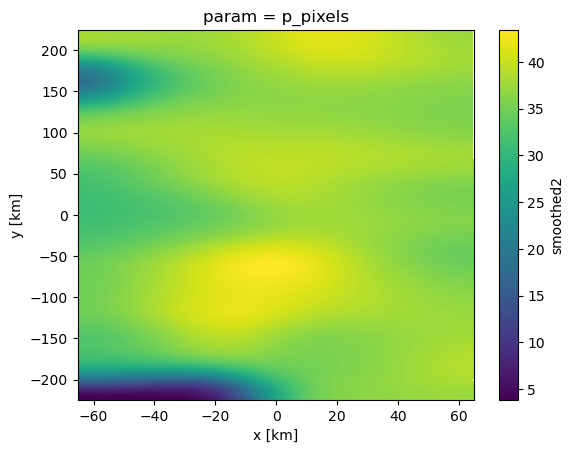

In [11]:
da_low.plot(x="x", y="y")

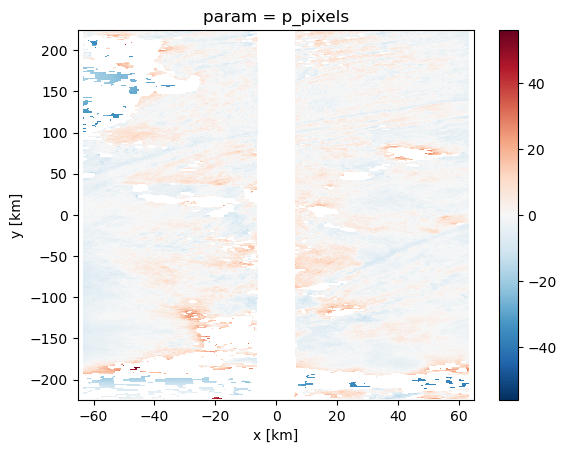

In [10]:
da_high.plot(x="x", y="y")

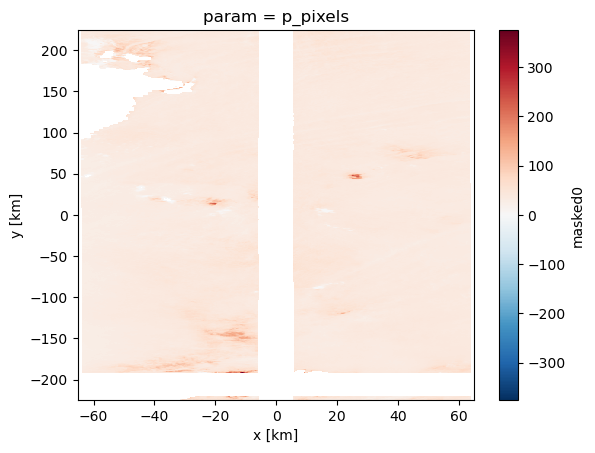

In [23]:
ds.masked0.plot(x="x", y="y")

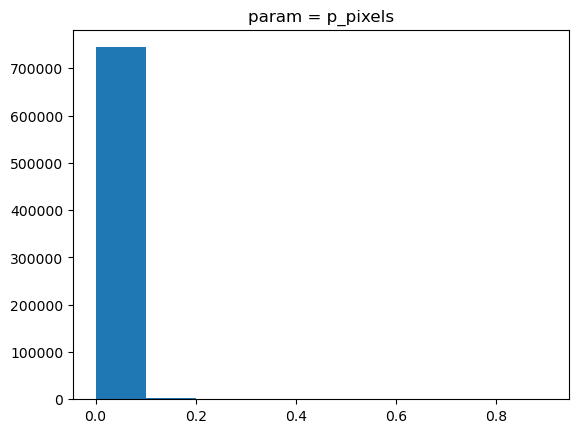

In [18]:
#(ds.masked0 - ds.smoothed0).plot.hist(bins=np.arange(-1e-1,1e-1,2e-3)); # ssh
np.abs((ds.masked0 - ds.smoothed0)/ds.smoothed0).plot.hist(bins=np.arange(0,1,1e-1)); # 

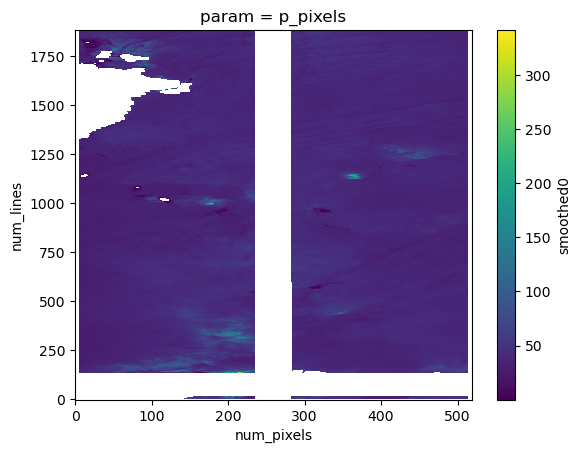

In [25]:
# still anomalous values present
ds.smoothed0.plot()

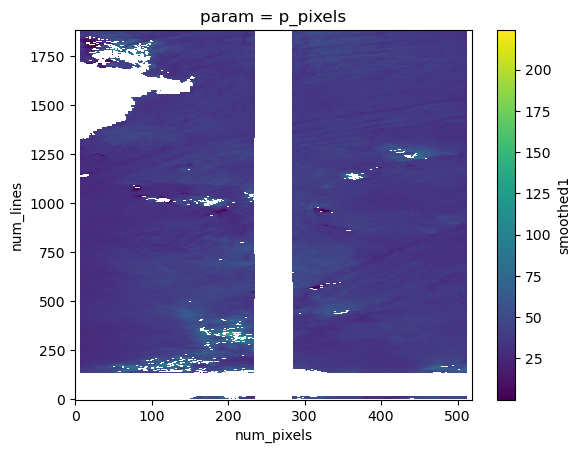

In [26]:
ds.smoothed1.plot()

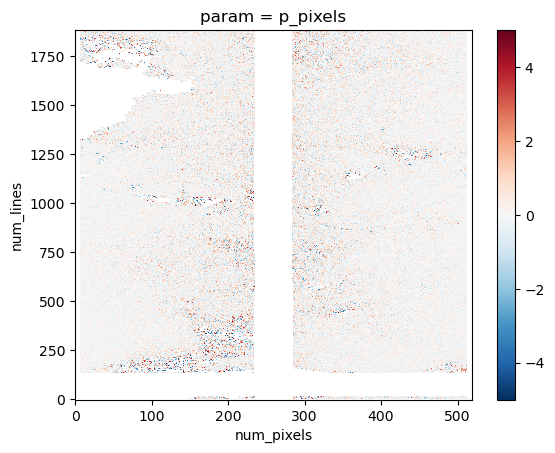

In [29]:
(ds.masked1 - ds.smoothed1).plot()

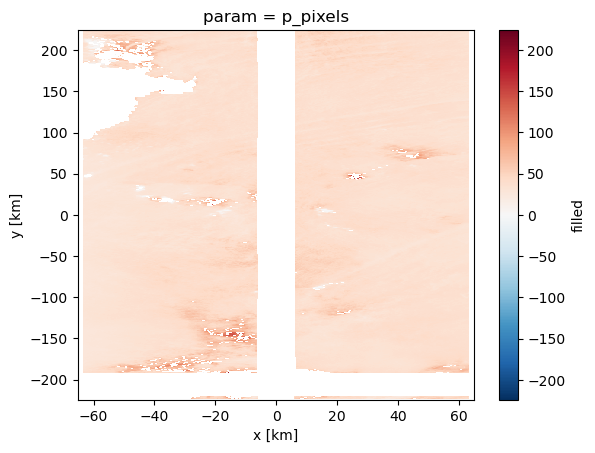

In [30]:
ds.filled.plot(x="x", y="y")

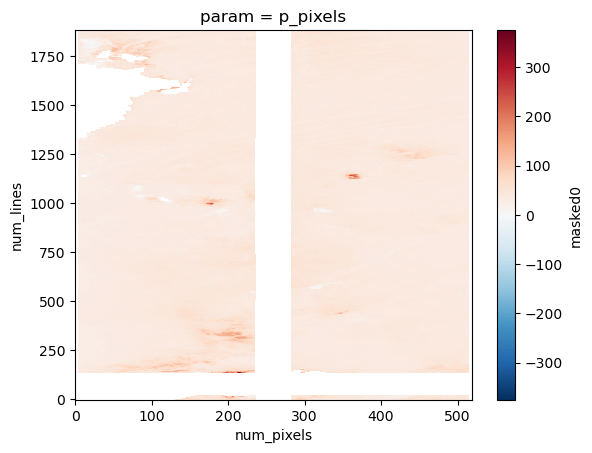

In [35]:
ds.masked0.plot()

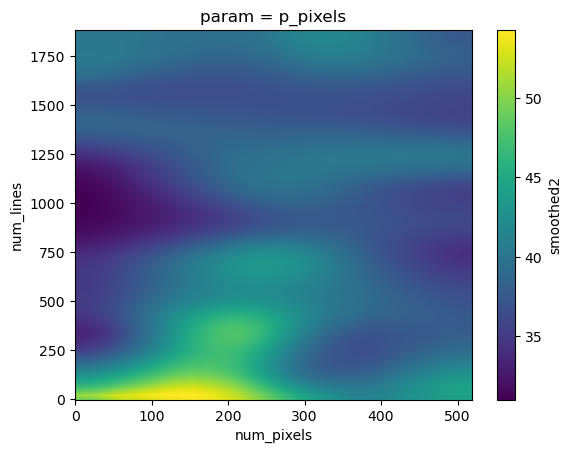

In [33]:
da_low.plot(vmax=None)

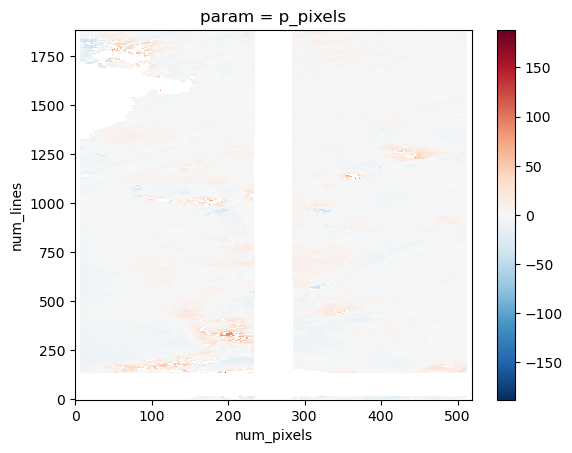

In [32]:
da_high.plot(vmax=None)

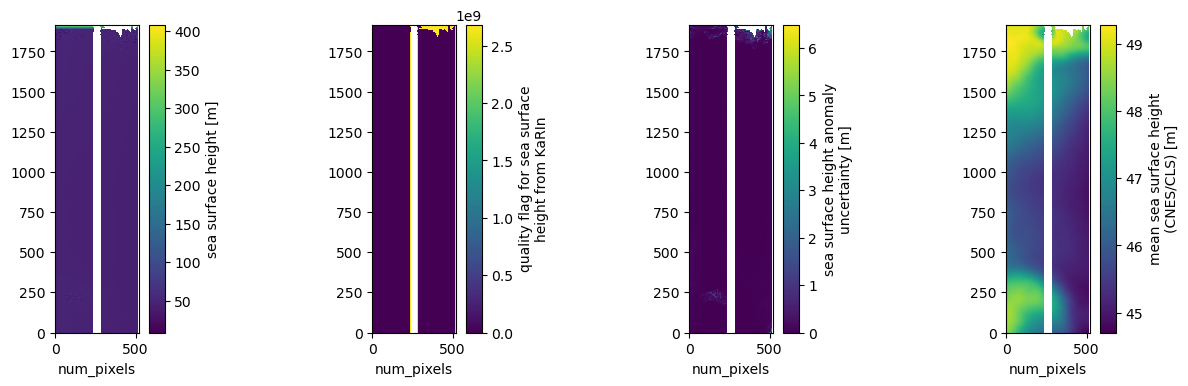

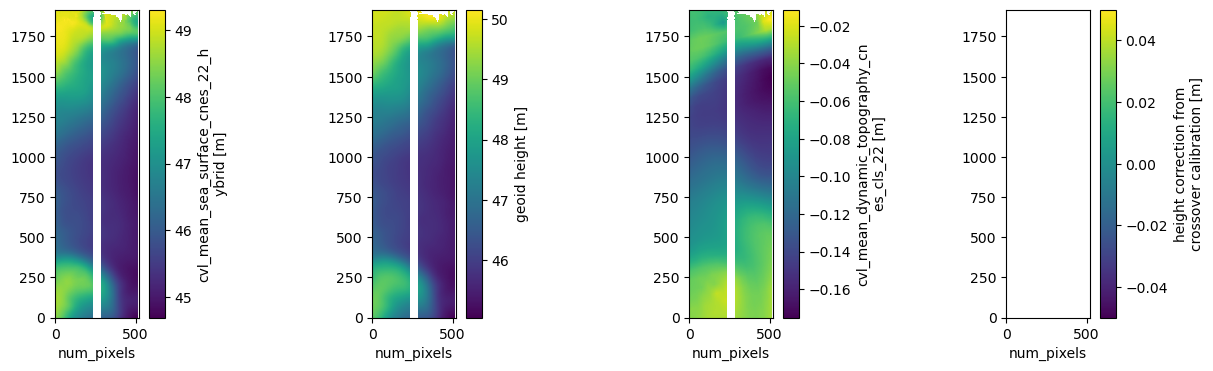

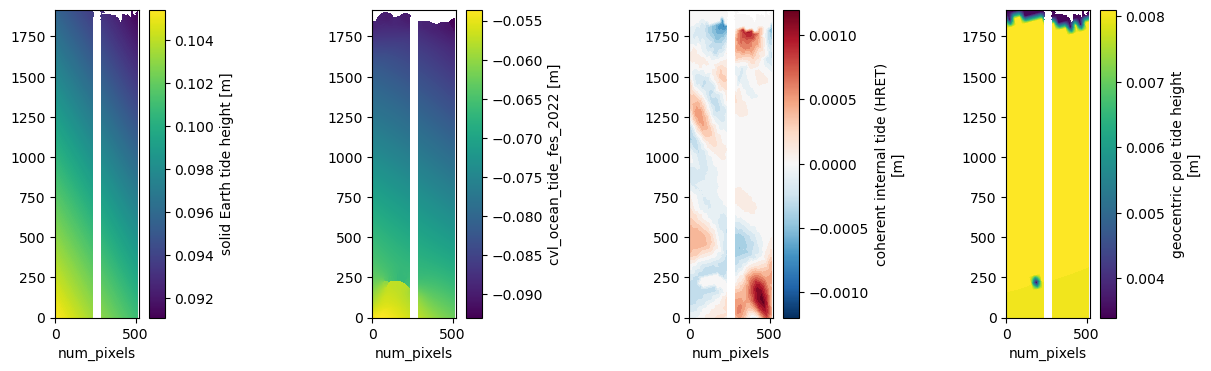

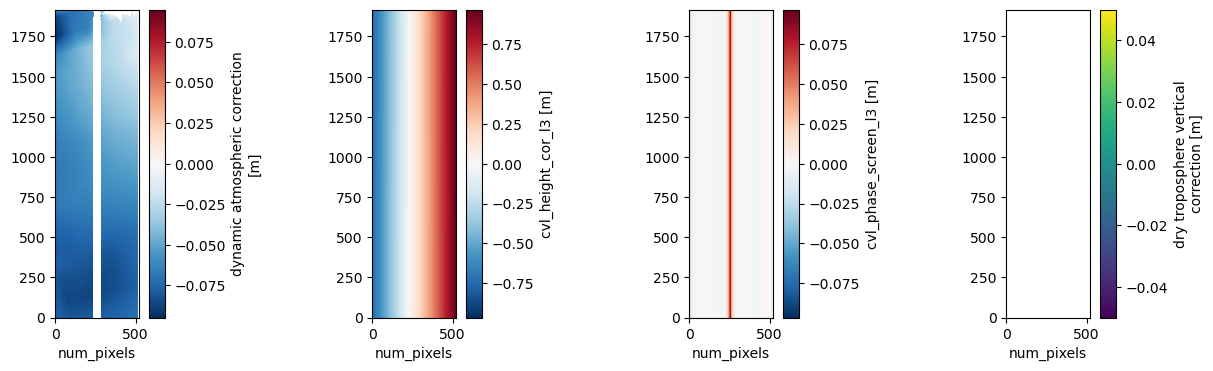

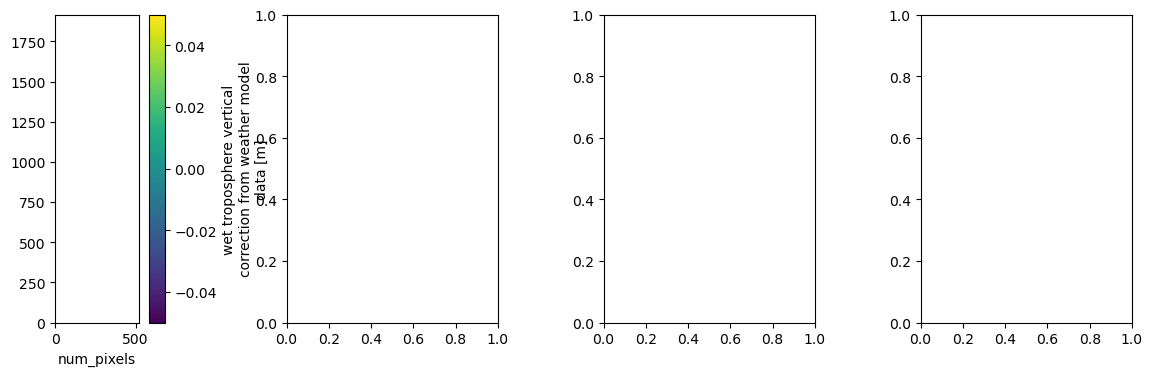

In [20]:
nx = 4

i=0
for v in sd.l2["ssh"]:
    if i%nx==0:
        fig, axes = plt.subplots(1, nx, figsize=(15,4), gridspec_kw=dict(wspace=.5))
        i = 0
    ax = axes[i]
    ds_l2[v].plot(ax=ax)
    ax.set_title("")
    ax.set_aspect("equal")
    ax.set_ylabel("")
    ax.set_xtick
    i+=1

---

In [ ]:
client.close()
cluster.close()